In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pylab as plt
import numpy as np
import torch
import swyft

In [3]:
class Simulator(swyft.Simulator):
    def __init__(self, bounds = None):
        super().__init__()
        self.on_after_forward = swyft.to_numpy32
        
    def forward(self, trace):
        z = trace.sample('z', np.random.rand, 3)
        x = trace.sample('x', lambda z: z + np.random.randn(3)*0.02, z)

In [4]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__(lr=1e-3)
        self.classifier = swyft.RatioEstimatorMLP1d(3, 3, hidden_features = 256, dropout = 0.1)
        
    def forward(self, A, B):
        x = A['x']
        z = B['z']
        ratios_z = self.classifier(x, z)
        return dict(z = ratios_z)

In [5]:
simulator = Simulator()

In [6]:
samples = simulator(100)
noise_hook = simulator.get_resampler(['x'])

100%|██████████| 100/100 [00:00<00:00, 28130.81it/s]


In [7]:
dl_train = samples[:80].get_dataloader(batch_size = 4, shuffle = True)
dl_valid = samples[80:90].get_dataloader(batch_size = 4)
dl_test = samples[90:].get_dataloader(batch_size = 4)

In [8]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 100, **swyft.tensorboard_config(name = '04-minimal-example', version=None))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [9]:
network = Network()

In [10]:
trainer.fit(network, dl_train, dl_valid)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                | Params
---------------------------------------------------
0 | classifier | RatioEstimatorMLP1d | 800 K 
---------------------------------------------------
800 K     Trainable params
0         Non-trainable params
800 K     Total params
3.201     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  87%|████████▋ | 20/23 [00:00<00:00, 104.60it/s, loss=-1.38, v_num=2] 
Validating: 0it [00:00, ?it/s]
Epoch 1:  87%|████████▋ | 20/23 [00:00<00:00, 104.24it/s, loss=-2.03, v_num=2, val_loss=0.039]
Validating: 0it [00:00, ?it/s]
Epoch 2:  87%|████████▋ | 20/23 [00:00<00:00, 94.43it/s, loss=-2.59, v_num=2, val_loss=-.366] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  87%|████████▋ | 20/23 [00:00<00:00, 103.67it/s, loss=-2.71, v_num=2, val_loss=-.647]
Validating: 0it [00:00, ?it/s]
Epoch 4:  87%|████████▋ | 20/23 [00:00<00:00, 96.24it/s, loss=-2.84, v_num=2, val_loss=-.778] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  87%|████████▋ | 20/23 [00:00<00:00, 108.28it/s, loss=-3.09, v_num=2, val_loss=-.183]
Validating: 0it [00:00, ?it/s]
Epoch 6:  87%|████████▋ | 20/23 [00:00<00:00, 99.69it/s, loss=-2.88, v_num=2, val_loss=-.887] 
Validating: 0it [00:00, ?it/s]
Epoch 7:  87%|████████▋ | 20/23 [00:00<00:00, 104.30it/s, loss=-2.95, v_num=2, val_loss=-.943]
Validating: 0it [00:00, ?it/s]
Epoch 8

In [11]:
trainer.test(network, dl_test, ckpt_path = 'best')

Restoring states from the checkpoint path at ./lightning_logs/04-minimal-example/version_2/checkpoints/epoch=17-step=359.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./lightning_logs/04-minimal-example/version_2/checkpoints/epoch=17-step=359.ckpt
/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'hp/JS-div': -2.365774154663086, 'hp/KL-div': -9.894857406616211}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 3/3 [00:00<00:00, 167.56it/s]


[{'hp/JS-div': -2.365774154663086, 'hp/KL-div': -9.894857406616211}]

In [12]:
x0 = [0.3, 0.5, 0.7]
prior_samples = simulator(100000, targets = ['z'])

100%|██████████| 100000/100000 [00:01<00:00, 87475.13it/s]


In [13]:
predictions = trainer.infer(network, {'x': torch.tensor(x0)}, prior_samples.get_dataloader(batch_size = 1024))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 20it [00:00, ?it/s]

/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:174: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting: 100%|██████████| 98/98 [00:01<00:00, 52.60it/s]


In [14]:
post_samples = predictions.sample(100000)

0.05250309
0.019974574
0.039563436


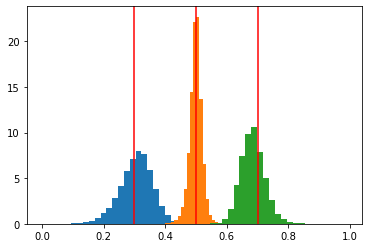

In [15]:
import pylab as plt
for i in range(3):
    s = post_samples['z'][:,i].numpy()
    print(s.std())
    plt.hist(s, bins = 30, density=True);
    plt.axvline(x0[i], color='r')